# Supervised Learning Models

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',35)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re, pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.svm import SVC
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

from radar_plotting import plot_radar

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

This notebook uses the data/labels created from the unsupervised learning notebook.

## Pre-Modeling Prep

In [2]:
df = pd.read_csv('results2/kmeans_results.csv')

In [3]:
df.head()

,Player,GP,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos,TEAM,Class
0,Aaron Gordon: 2015,78.0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,PF,ORL,2
1,Al Horford: 2015,82.0,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,C,ATL,2
2,Al Jefferson: 2015,47.0,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,C,CHA,3
3,Andre Drummond: 2015,81.0,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,C,DET,5
4,Andrew Bogut: 2015,70.0,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,C,GSW,2


**Classes:**

- 0: Ball-Dominant Scorer - "Best" player on a team, main contributor in anything offensive related
- 1: Role Player - Contributes but does not excel in any area
- 2: Stretch Big - Shoots more 3PT and drives in more than a traditional big in exchange for less rebounds
- 3: Traditional Big - Rebounds and blocks shots well, rarely shoots and almost exclusively takes shots inside
- 4: Secondary Guard - Drives and assists with above average 3PT shooting, shortest average height
- 5: High-Usage Big - Scores a lot, rebounds well, takes a lot of shots inside the paint at a high percentage

In [4]:
df['Class'].value_counts()

1    408
4    334
2    232
0    178
3    128
5    103
Name: Class, dtype: int64

In [8]:
df['Class'].value_counts() / df['Class'].shape[0]

1    0.295011
4    0.241504
2    0.167751
0    0.128706
3    0.092552
5    0.074476
Name: Class, dtype: float64

**Takeaways:**

- Around 30% of the players are classified as *Role Players*.
- *High-Usage Bigs* and *Traditional Bigs* each make up less than 10%, which makes sense because big men, themselves, are broken up into 3 different categories. 
- The most common non-Role Player is the *Secondary Guard* at almost 25%
- *Stretch Bigs* are the highest out of the big men categorizations at 16.8%, which makes sense considering the current era where more players are asked to shoot from distance.

## Model Functions & Metrics

**Build Model Function**

In [36]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True, n_classes=11):
    start = time.time()
    
    # make sure to uncomment the next line for logistic regression
    #clf = OneVsRestClassifier(model)
    
    # comment this next line for logistic regression
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
        
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score

**Plot Feature Importances** 

In [7]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.tight_layout()
    #plt.savefig('figures/semisupervised/phase_1_features')

**Plot Confusion Matrix**

In [8]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    #plt.savefig('figures/semisupervised/phase2_confusion')

**Plot Metrics**

In [9]:
def print_model_metrics(y_pred,y_score,y_test):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    f1 = f1_score(y_test,y_pred, average='micro')
    
    #print('Training Set Metrics:')
    print('Accuracy: {}\n'.format(round(accuracy,4)))
    print('Micro Precision: {}'.format(round(precision,4)))
    print('Micro Recall: {}'.format(round(recall,4)))
    print('Micro F1: {}\n'.format(round(f1,4)))

    print('Macro Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

## Categorical Variables

In [10]:
X = prelabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
y = prelabeled_df['Class']

In [11]:
# get dummy variables for position
X = pd.get_dummies(X, drop_first=True)
X.head()

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,1,0,0,0
1,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,0,0,0,0
2,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,0,0,0,0
3,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,0,0,0,0
4,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,0,0,0,0


## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [13]:
y_train

153    11.0
94      2.0
108     6.0
109    11.0
155     9.0
       ... 
240    11.0
313     6.0
143     3.0
241     2.0
111     1.0
Name: Class, Length: 264, dtype: float64

In [14]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Scale Data
Scaling is done after the train test split in order to ensure that the training set is not influenced at all by the test set.

In [15]:
# scale using MinMaxScaler
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.fit_transform(X_test)

# convert back into DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [16]:
X_train_scaled.head()

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,0.522222,0.409639,0.297059,0.272727,0.314,0.616667,0.277228,0.340426,0.388889,0.379310,0.534884,0.623377,0.366337,0.646177,0.438849,0.120192,0.8125,0.0,0.0,0.0,0.0
1,0.616667,0.237952,0.602941,0.000000,0.000,0.716667,0.089109,0.255319,0.111111,0.241379,0.488372,0.716883,0.128713,0.613193,0.223022,0.004808,0.7500,0.0,0.0,0.0,0.0
2,0.900000,0.445783,0.188235,0.310606,0.331,0.216667,0.138614,0.297872,0.444444,0.206897,0.503876,0.633766,0.455446,0.476762,0.179856,0.370192,0.5625,0.0,0.0,1.0,0.0
3,0.905556,0.759036,0.470588,0.166667,0.340,0.775000,0.168317,0.404255,0.666667,0.896552,0.875969,0.815584,0.534653,0.545727,0.460432,0.197115,0.6875,1.0,0.0,0.0,0.0
4,0.916667,0.572289,0.164706,0.583333,0.401,0.325000,0.267327,0.510638,0.944444,0.172414,0.372093,0.529870,0.376238,0.497751,0.071942,0.427885,0.6250,0.0,0.0,1.0,0.0


# Stage 1 Modeling

Modeling is done on the prelabeled data for this stage. The model created will be used to make predictions on the non-labeled data. In Stage 2, that newly labeled data will be used to create a new model.

## Random Forest

In [21]:
# tried scaled data as well, but better results achieved with non-scaled data
rf, rf_y_preds, rf_y_score = build_model(RandomForestClassifier(),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 0.22358298301696777 seconds


Accuracy: 0.7045

Micro Precision: 0.7045
Micro Recall: 0.7045
Micro F1: 0.7045

Macro Precision: 0.7203
Macro Recall: 0.7424
Macro F1-score: 0.7196

Weighted Precision: 0.7042
Weighted Recall: 0.7045
Weighted F1-score: 0.6933


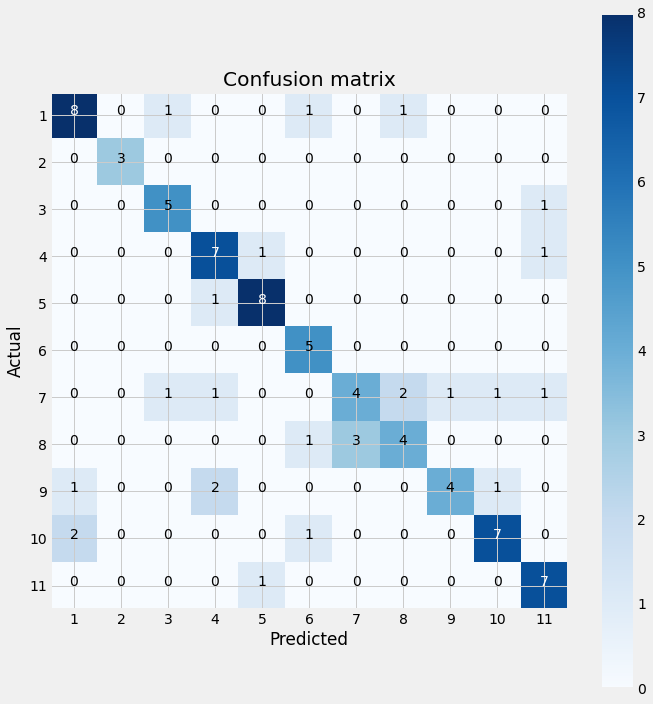

In [22]:
print_model_metrics(rf_y_preds, rf_y_score, y_test)

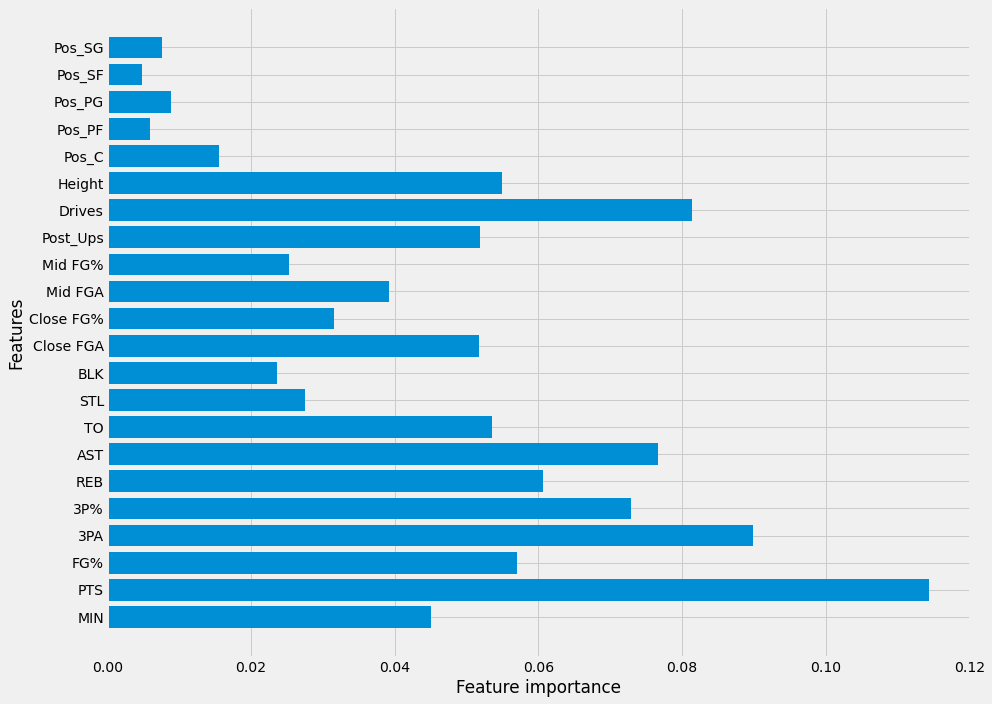

In [23]:
plot_feature_importances(rf)

**Gridsearch**

In [24]:
rf_param_grid = {"n_estimators": [100, 200, 300],
                  "min_samples_leaf": [3, 5],
                  "min_samples_split": [5,10,15],
                  "criterion": ["gini", "entropy"]
                }

In [25]:
rf_gs, rf_gs_y_preds, rf_gs_y_score = build_model(GridSearchCV(rf, param_grid=rf_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 49.40139603614807 seconds


Accuracy: 0.7159

Micro Precision: 0.7159
Micro Recall: 0.7159
Micro F1: 0.7159

Macro Precision: 0.7368
Macro Recall: 0.7432
Macro F1-score: 0.7117

Weighted Precision: 0.7378
Weighted Recall: 0.7159
Weighted F1-score: 0.6993


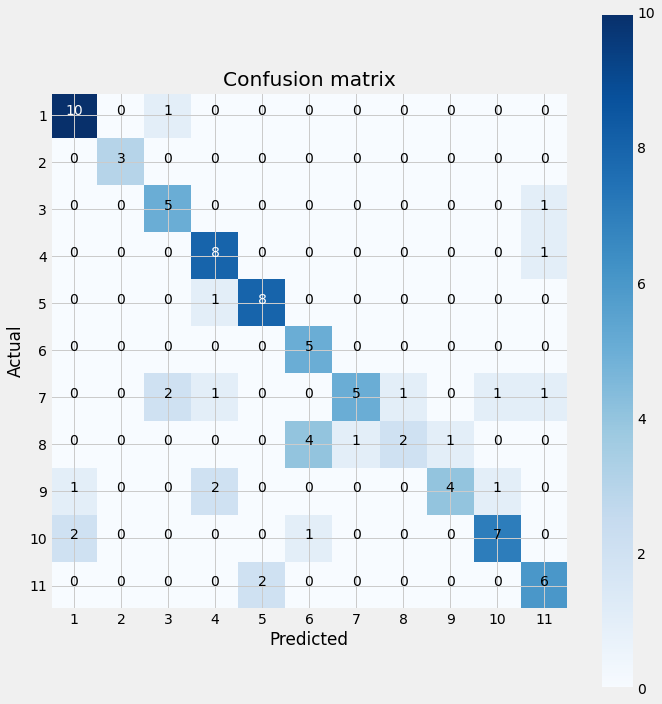

In [26]:
print_model_metrics(rf_gs_y_preds, rf_gs_y_score, y_test)

In [27]:
rf_gs.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [28]:
rf_gs.best_score_

0.7234397677793905

In [29]:
print(f'Training Accuracy: {rf_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {rf_gs.score(X_test, y_test)}')

Training Accuracy: 0.9621212121212122
Test Accuracy: 0.7159090909090909


## Gradient Boost

In [30]:
gb, gb_y_preds, gb_y_score = build_model(GradientBoostingClassifier(),
                                         X_train, X_test, y_train, y_test)

Total Runtime: 1.398892879486084 seconds


Accuracy: 0.6818

Micro Precision: 0.6818
Micro Recall: 0.6818
Micro F1: 0.6818

Macro Precision: 0.7044
Macro Recall: 0.6738
Macro F1-score: 0.6788

Weighted Precision: 0.7063
Weighted Recall: 0.6818
Weighted F1-score: 0.6843


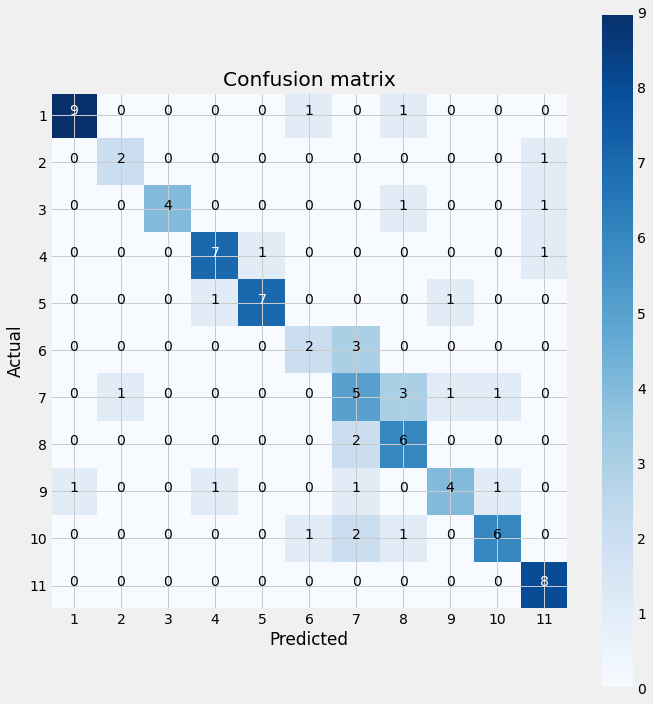

In [31]:
print_model_metrics(gb_y_preds, gb_y_score, y_test)

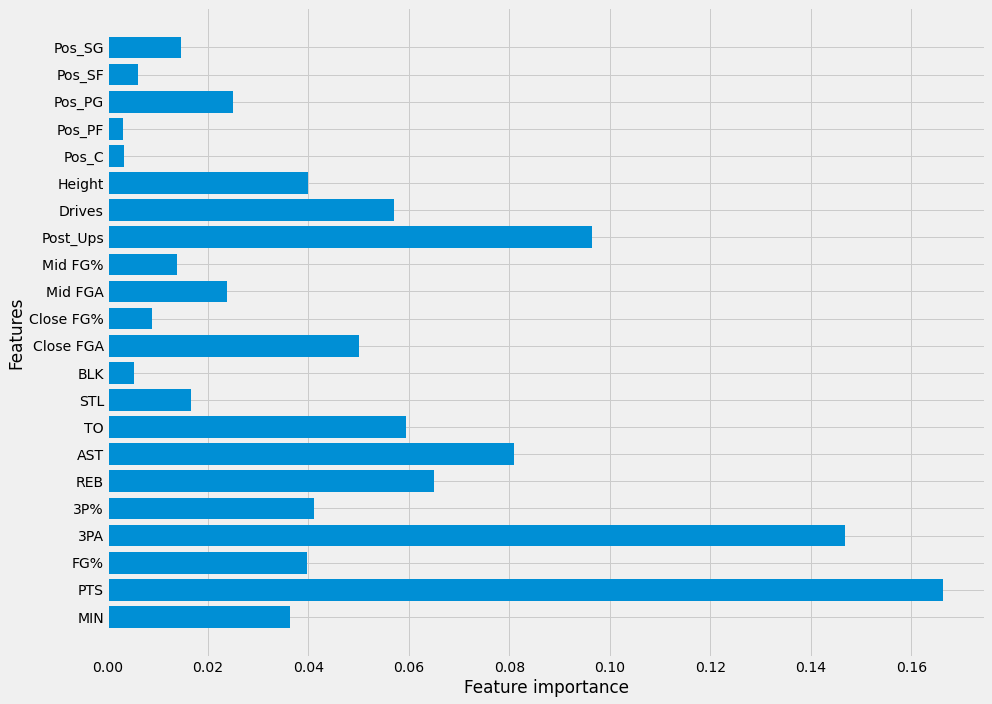

In [32]:
plot_feature_importances(gb)

**Gridsearch**

In [33]:
gb_param_grid = {"n_estimators": [50, 100, 250],
                  "learning_rate": [.005, .01, .1]
                }

gb_gs, gb_gs_y_preds, gb_gs_y_score = build_model(GridSearchCV(gb, param_grid=gb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 72.8404688835144 seconds


Accuracy: 0.6705

Micro Precision: 0.6705
Micro Recall: 0.6705
Micro F1: 0.6705

Macro Precision: 0.6643
Macro Recall: 0.6595
Macro F1-score: 0.6559

Weighted Precision: 0.6771
Weighted Recall: 0.6705
Weighted F1-score: 0.6678


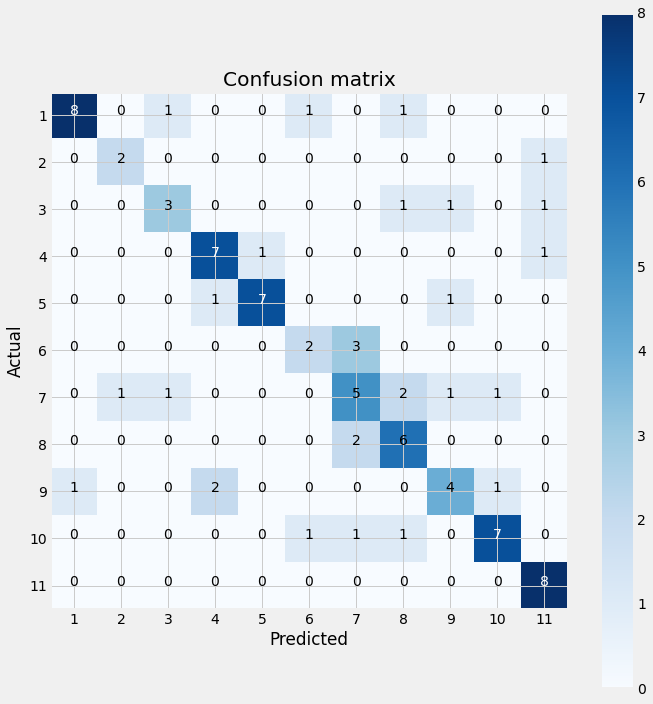

In [34]:
print_model_metrics(gb_gs_y_preds, gb_gs_y_score, y_test)

In [35]:
print(gb_gs.best_params_)

print(f'Training Accuracy: {gb_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {gb_gs.score(X_test, y_test)}')

{'learning_rate': 0.1, 'n_estimators': 100}
Training Accuracy: 1.0
Test Accuracy: 0.6704545454545454


## AdaBoost

In [36]:
ada, ada_y_preds, ada_y_score = build_model(AdaBoostClassifier(algorithm="SAMME",
                                                              learning_rate=.05),
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.11799192428588867 seconds


Accuracy: 0.1818

Micro Precision: 0.1818
Micro Recall: 0.1818
Micro F1: 0.1818

Macro Precision: 0.0844
Macro Recall: 0.2626
Macro F1-score: 0.1107

Weighted Precision: 0.0790
Weighted Recall: 0.1818
Weighted F1-score: 0.0970


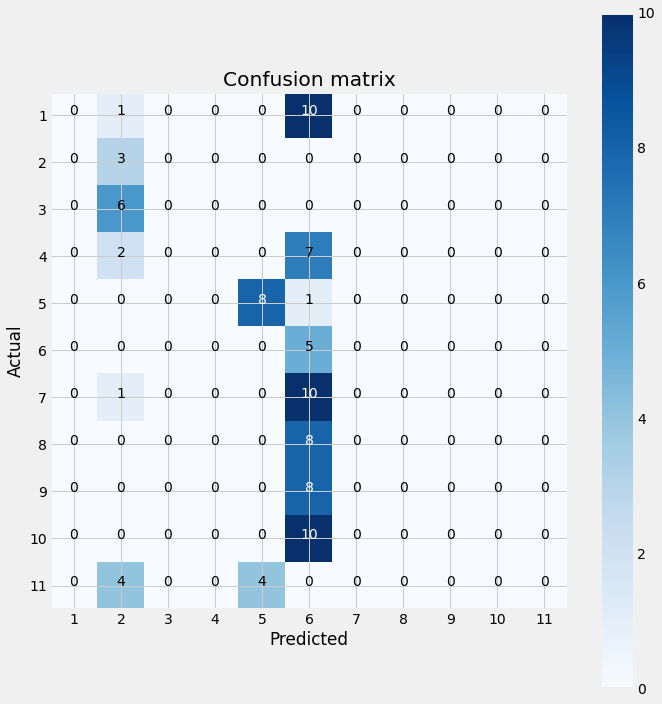

In [37]:
print_model_metrics(ada_y_preds, ada_y_score, y_test)

## XGBoost

In [38]:
xgb, xgb_y_preds, xgb_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 0.32630300521850586 seconds


Accuracy: 0.7273

Micro Precision: 0.7273
Micro Recall: 0.7273
Micro F1: 0.7273

Macro Precision: 0.7264
Macro Recall: 0.7240
Macro F1-score: 0.7161

Weighted Precision: 0.7440
Weighted Recall: 0.7273
Weighted F1-score: 0.7257


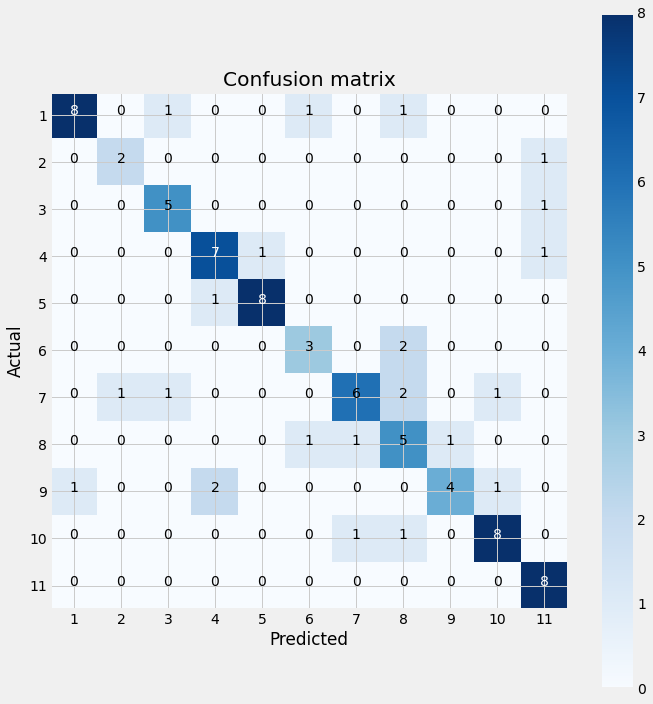

In [39]:
print_model_metrics(xgb_y_preds, xgb_y_score, y_test)

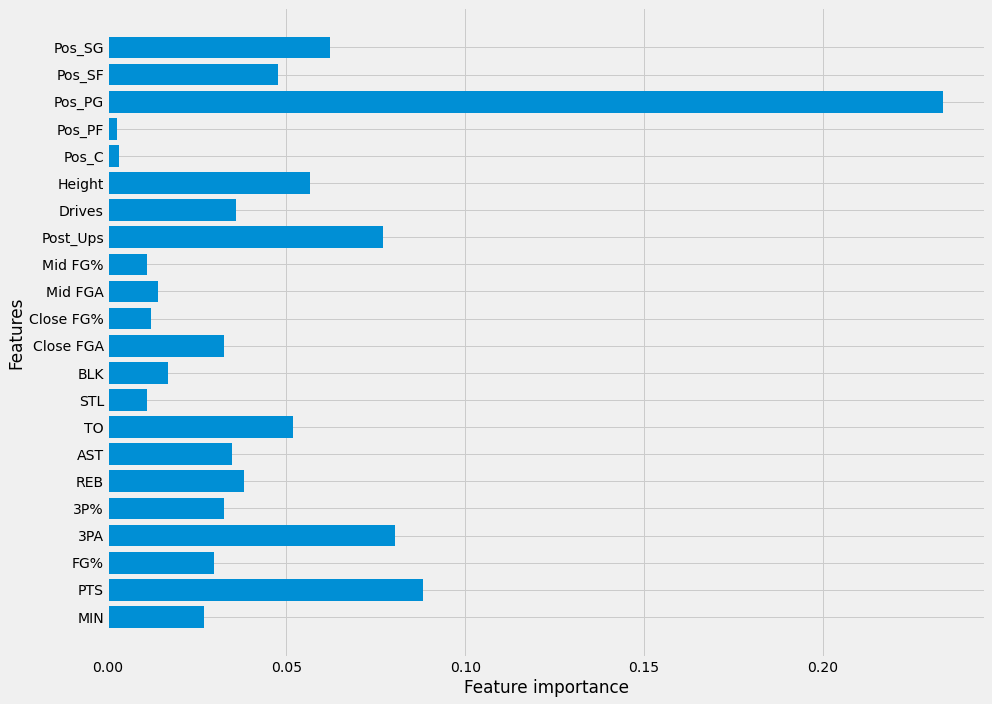

In [40]:
plot_feature_importances(xgb)

In [52]:
%reset_selective -f xgb_gs

In [49]:
xgb_param_grid = {"min_child_weight": [1, 2],
                  "max_depth": [4, 6, 7],
                  "learning_rate": [.001, .01, .1]
                }

xgb_gs, xgb_gs_y_preds, xgb_gs_y_score = build_model(GridSearchCV(xgb, param_grid=xgb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 26.485565900802612 seconds


Accuracy: 0.7273

Micro Precision: 0.7273
Micro Recall: 0.7273
Micro F1: 0.7273

Macro Precision: 0.7412
Macro Recall: 0.7195
Macro F1-score: 0.7140

Weighted Precision: 0.7478
Weighted Recall: 0.7273
Weighted F1-score: 0.7223


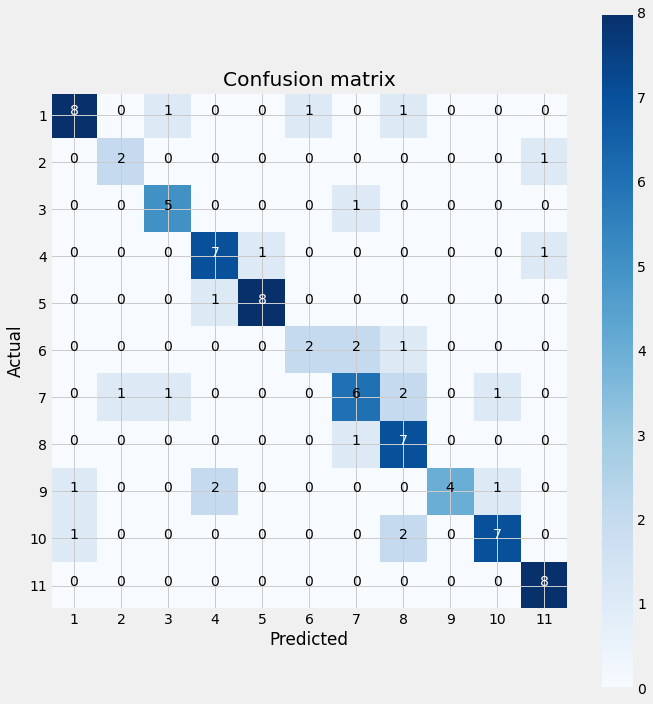

In [50]:
print_model_metrics(xgb_gs_y_preds, xgb_gs_y_score, y_test)

In [51]:
xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1}

Try manually tuning as well.

In [20]:
%reset_selective -f xgb_man

In [32]:
xgb_man, xgb_man_y_preds, xgb_man_y_score = build_model(XGBClassifier(objective='multi:softmax',
                                                                     learning_rate=.1,
                                                                     n_estimators=1000,
                                                                     max_depth=3,
                                                                     colsample_bytree=.8), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 1.015868902206421 seconds


Accuracy: 0.7614

Micro Precision: 0.7614
Micro Recall: 0.7614
Micro F1: 0.7614

Macro Precision: 0.7833
Macro Recall: 0.7740
Macro F1-score: 0.7619

Weighted Precision: 0.7845
Weighted Recall: 0.7614
Weighted F1-score: 0.7559


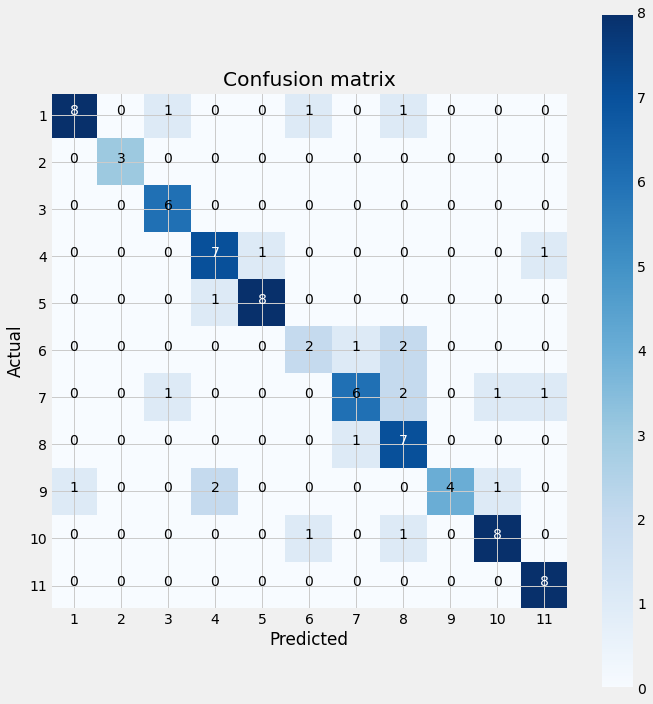

In [33]:
print_model_metrics(xgb_man_y_preds, xgb_man_y_score, y_test)

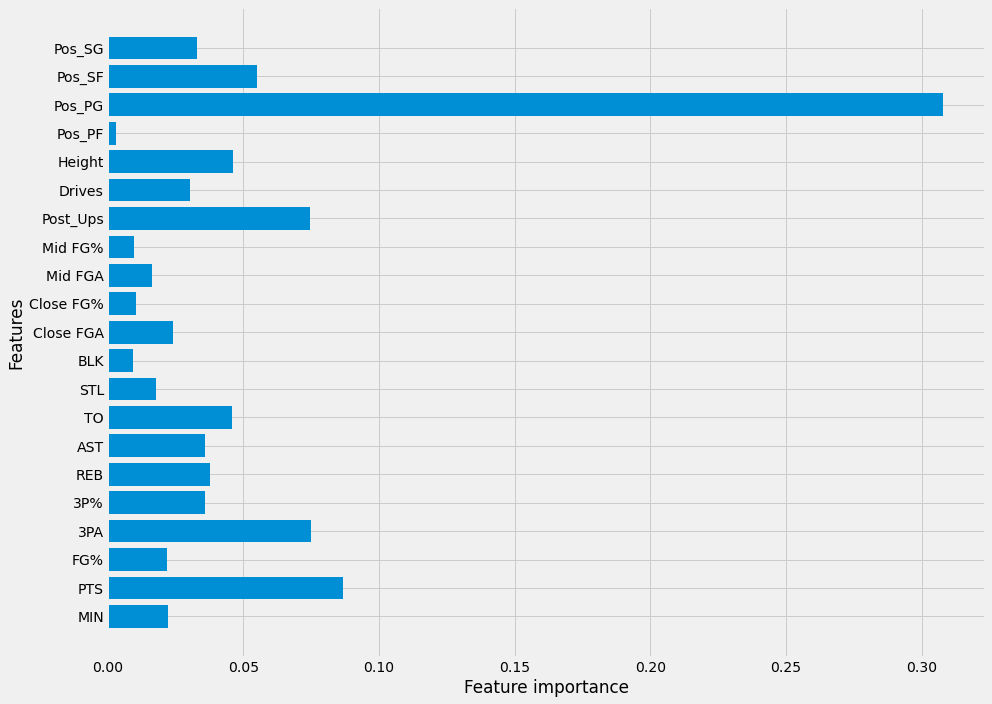

In [34]:
plot_feature_importances(xgb_man)

In [35]:
print(f'Training Accuracy: {xgb_man.score(X_train, y_train)}')
print(f'Test Accuracy: {xgb_man.score(X_test, y_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.7613636363636364


## SVM: Support Vector Machine

In [27]:
%reset_selective -f svm

In [30]:
svm, svm_y_preds, svm_y_score = build_model(SVC(kernel='poly', degree=11,decision_function_shape='ovo'), 
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.01358485221862793 seconds


Accuracy: 0.5909

Micro Precision: 0.5909
Micro Recall: 0.5909
Micro F1: 0.5909

Macro Precision: 0.5480
Macro Recall: 0.5508
Macro F1-score: 0.5404

Weighted Precision: 0.5993
Weighted Recall: 0.5909
Weighted F1-score: 0.5873


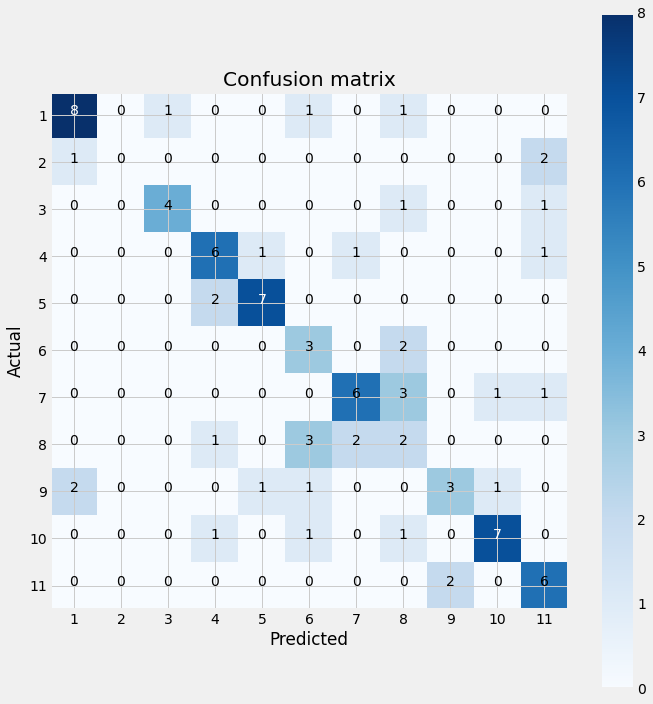

In [31]:
print_model_metrics(svm_y_preds, svm_y_score, y_test)

## Neural Network

In [17]:
# binarize target column

binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y_train)

In [34]:
%reset_selective -f model_1

In [37]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(21,)))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dense(11, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [38]:
model_1_results = model_1.fit(X_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
7/7 [==============================] - 0s 22ms/step - loss: 2.4517 - acc: 0.1090 - val_loss: 2.3606 - val_acc: 0.0943
Epoch 2/150
7/7 [==============================] - 0s 3ms/step - loss: 2.3402 - acc: 0.1943 - val_loss: 2.3130 - val_acc: 0.1321
Epoch 3/150
7/7 [==============================] - 0s 3ms/step - loss: 2.2603 - acc: 0.2180 - val_loss: 2.2602 - val_acc: 0.1887
Epoch 4/150
7/7 [==============================] - 0s 5ms/step - loss: 2.1864 - acc: 0.2180 - val_loss: 2.2020 - val_acc: 0.2075
Epoch 5/150
7/7 [==============================] - 0s 4ms/step - loss: 2.1170 - acc: 0.2512 - val_loss: 2.1393 - val_acc: 0.2453
Epoch 6/150
7/7 [==============================] - 0s 4ms/step - loss: 2.0484 - acc: 0.3175 - val_loss: 2.0728 - val_acc: 0.2830
Epoch 7/150
7/7 [==============================] - 0s 4ms/step - loss: 1.9818 - acc: 0.3460 - val_loss: 2.0066 - val_acc: 0.3208
Epoch 8/150
7/7 [==============================] - 0s 4ms/step - loss: 1.9229 - acc: 0.3839 - va

7/7 [==============================] - 0s 3ms/step - loss: 0.8273 - acc: 0.7441 - val_loss: 0.9327 - val_acc: 0.6415
Epoch 65/150
7/7 [==============================] - 0s 3ms/step - loss: 0.8222 - acc: 0.7536 - val_loss: 0.9305 - val_acc: 0.6415
Epoch 66/150
7/7 [==============================] - 0s 3ms/step - loss: 0.8140 - acc: 0.7536 - val_loss: 0.9245 - val_acc: 0.6415
Epoch 67/150
7/7 [==============================] - 0s 3ms/step - loss: 0.8089 - acc: 0.7630 - val_loss: 0.9120 - val_acc: 0.6415
Epoch 68/150
7/7 [==============================] - 0s 3ms/step - loss: 0.8027 - acc: 0.7725 - val_loss: 0.9094 - val_acc: 0.6792
Epoch 69/150
7/7 [==============================] - 0s 3ms/step - loss: 0.7983 - acc: 0.7820 - val_loss: 0.8994 - val_acc: 0.6981
Epoch 70/150
7/7 [==============================] - 0s 3ms/step - loss: 0.7919 - acc: 0.7725 - val_loss: 0.8973 - val_acc: 0.6792
Epoch 71/150
7/7 [==============================] - 0s 3ms/step - loss: 0.7853 - acc: 0.7678 - val_loss

Epoch 127/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5583 - acc: 0.8436 - val_loss: 0.7747 - val_acc: 0.7547
Epoch 128/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5589 - acc: 0.8199 - val_loss: 0.7705 - val_acc: 0.7547
Epoch 129/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5517 - acc: 0.8199 - val_loss: 0.7844 - val_acc: 0.7358
Epoch 130/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5506 - acc: 0.8294 - val_loss: 0.7850 - val_acc: 0.7358
Epoch 131/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5463 - acc: 0.8341 - val_loss: 0.7850 - val_acc: 0.7547
Epoch 132/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5451 - acc: 0.8341 - val_loss: 0.7896 - val_acc: 0.7170
Epoch 133/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5422 - acc: 0.8246 - val_loss: 0.7827 - val_acc: 0.7358
Epoch 134/150
7/7 [==============================] - 0s 3ms/step - loss: 0.5377 - a

# Stage 2 Modeling

This stage will create predictions from the previous model on the non-labeled data. Afterwards, the predictions will be used to train a new model.

The best model from the previous stage was the XGBoost.

## Data Preparation

In [20]:
# make predictions

pred_set = unlabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
pred_set = pd.get_dummies(pred_set, drop_first=True)
pred_set.head()

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,28.5,10.2,41.6,4.3,36.1,6.1,1.7,1.5,0.9,0.6,3.4,50.0,1.1,37.6,0.4,3.5,81.0,0,0,1,0
1,25.7,13.3,41.0,2.5,40.5,3.5,2.0,1.6,0.6,0.1,5.1,47.1,3.1,32.3,0.0,8.0,78.0,0,0,0,1
2,23.3,9.0,42.3,0.1,14.3,7.6,1.2,1.9,0.5,0.8,5.4,46.3,2.5,32.6,5.0,0.6,85.0,0,0,0,0
3,26.0,10.3,45.9,3.5,39.3,2.7,1.2,0.8,0.8,0.2,1.7,58.8,3.1,44.8,0.1,1.8,78.0,0,0,0,1
4,22.4,4.5,51.8,0.8,28.3,3.4,1.0,0.8,0.9,0.2,2.3,65.2,0.4,25.0,0.1,1.5,78.0,0,0,1,0


In [21]:
unlabeled_df['Class'] = xgb_man.predict(pred_set)
unlabeled_df

,Player,GP,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos,Class,TEAM
0,Al-Farouq Aminu: 2015,82.0,28.5,10.2,41.6,4.3,36.1,6.1,1.7,1.5,0.9,0.6,3.4,50.0,1.1,37.6,0.4,3.5,81.0,SF,10,POR
1,Alec Burks: 2015,31.0,25.7,13.3,41.0,2.5,40.5,3.5,2.0,1.6,0.6,0.1,5.1,47.1,3.1,32.3,0.0,8.0,78.0,SG,6,UTA
2,Alex Len: 2015,78.0,23.3,9.0,42.3,0.1,14.3,7.6,1.2,1.9,0.5,0.8,5.4,46.3,2.5,32.6,5.0,0.6,85.0,C,2,PHX
3,Allen Crabbe: 2015,81.0,26.0,10.3,45.9,3.5,39.3,2.7,1.2,0.8,0.8,0.2,1.7,58.8,3.1,44.8,0.1,1.8,78.0,SG,1,POR
4,Alonzo Gee: 2015,73.0,22.4,4.5,51.8,0.8,28.3,3.4,1.0,0.8,0.9,0.2,2.3,65.2,0.4,25.0,0.1,1.5,78.0,SF,10,NOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,Wayne Ellington: 2020,31.0,23.2,10.7,45.8,6.4,43.1,1.8,1.5,0.7,0.4,0.2,1.1,63.6,0.7,40.0,0.0,1.9,76.0,SG,1,DET
1027,Wendell Carter Jr: 2020,32.0,24.7,10.9,51.2,0.7,36.4,7.8,2.2,1.5,0.6,0.8,5.9,55.9,1.2,38.5,2.5,1.0,82.0,C,2,ORL
1028,Wesley Matthews: 2020,37.0,20.1,4.5,35.9,3.3,34.7,1.4,1.0,0.5,0.5,0.4,0.6,50.0,0.3,20.0,0.3,1.2,76.0,SG,10,LAL
1029,Will Barton: 2020,41.0,30.7,12.7,43.5,4.7,37.7,4.1,3.1,1.7,0.9,0.4,5.2,50.0,1.2,41.7,0.0,6.1,78.0,SF,8,DEN


In [22]:
# combine prelabeled data and predictions into one dataset
new_labeled_df = pd.concat([prelabeled_df, unlabeled_df])

Now we need to make our X and y sets, along with a scaled version of X. Then, we split the data using train_test_split to get our training and testing sets.

In [23]:
X2 = new_labeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
X2 = pd.get_dummies(X2, drop_first=True)
y2 = new_labeled_df['Class']

In [24]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=17)

Create a scaled set as well to use.

In [25]:
y2_train = y2_train.astype(int)
y2_test = y2_test.astype(int)

# scale using MinMaxScaler
mm = MinMaxScaler()
X2_train_scaled = mm.fit_transform(X2_train)
X2_test_scaled = mm.fit_transform(X2_test)

# convert back into DataFrame to preserve column names
X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=X2.columns)
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns=X2.columns)

## Modeling

### Random Forest

In [55]:
# tried scaled data as well, but better results achieved with non-scaled data
rf2, rf2_y_preds, rf2_y_score = build_model(RandomForestClassifier(),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 0.28144264221191406 seconds


Accuracy: 0.7746

Micro Precision: 0.7746
Micro Recall: 0.7746
Micro F1: 0.7746

Macro Precision: 0.7709
Macro Recall: 0.7630
Macro F1-score: 0.7560

Weighted Precision: 0.7844
Weighted Recall: 0.7746
Weighted F1-score: 0.7698


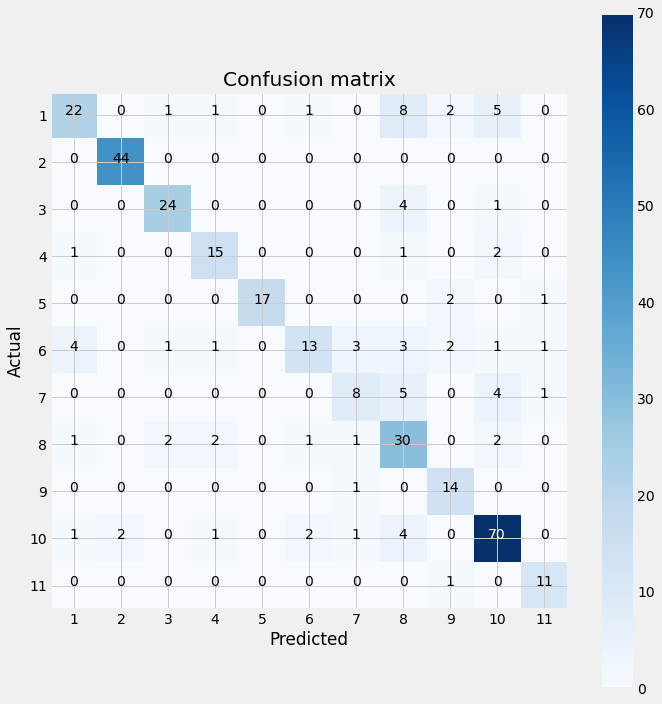

In [56]:
print_model_metrics(rf2_y_preds, rf2_y_score, y2_test)

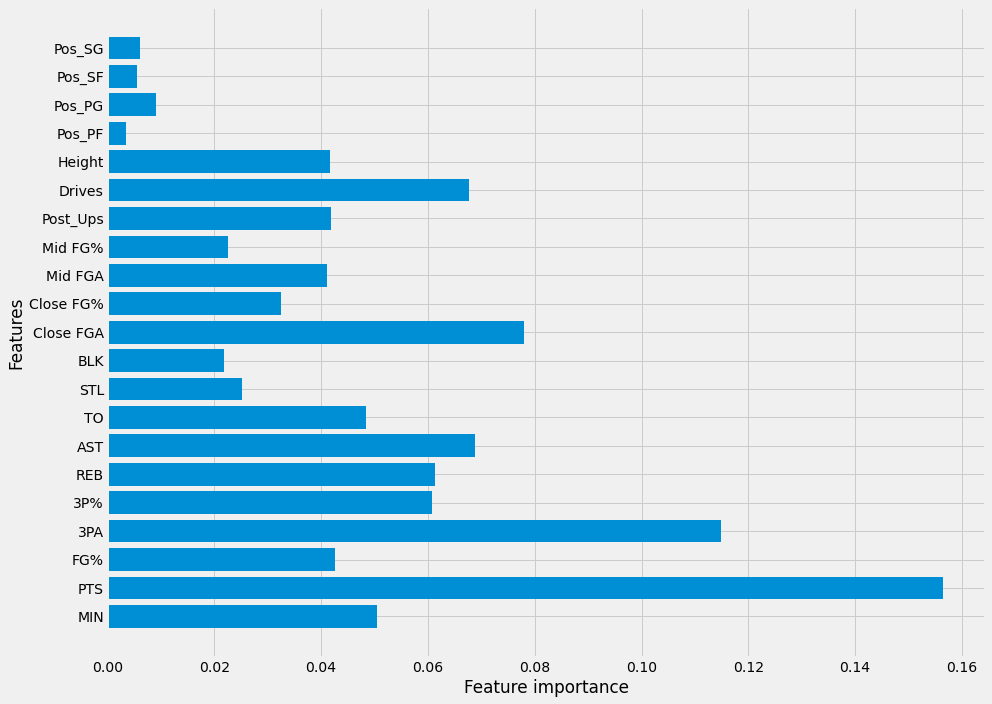

In [57]:
plot_feature_importances(rf2)

In [58]:
print(f'Training Accuracy: {rf2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {rf2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.7745664739884393


**Gridsearch**

In [59]:
rf2_param_grid = {"min_samples_leaf": [1, 3, 5],
                  "min_samples_split": [2, 4, 6],
                  "criterion": ["gini", "entropy"],
                  "n_estimators": [100, 200, 300]
                }

In [60]:
rf2_gs, rf2_gs_y_preds, rf2_gs_y_score = build_model(GridSearchCV(rf2, param_grid=rf2_param_grid),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 111.23376989364624 seconds


Accuracy: 0.7775

Micro Precision: 0.7775
Micro Recall: 0.7775
Micro F1: 0.7775

Macro Precision: 0.7693
Macro Recall: 0.7694
Macro F1-score: 0.7615

Weighted Precision: 0.7773
Weighted Recall: 0.7775
Weighted F1-score: 0.7715


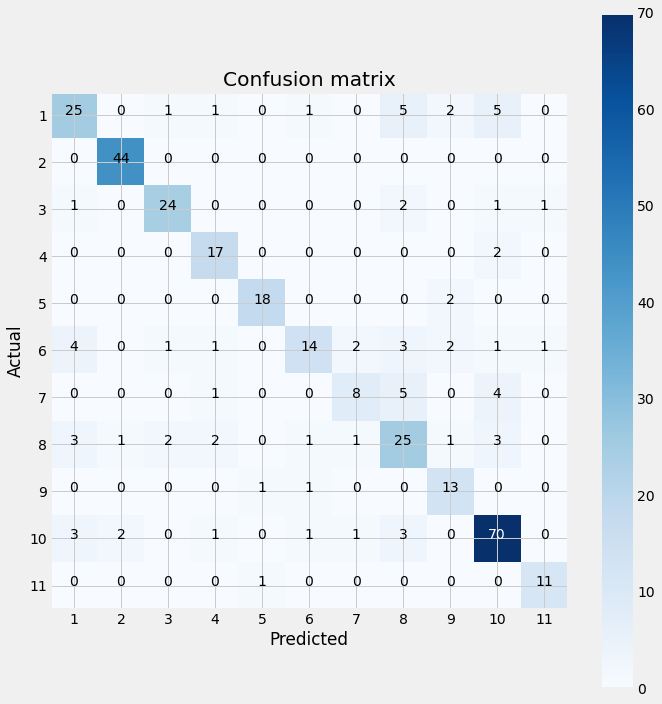

In [61]:
print_model_metrics(rf2_gs_y_preds, rf2_gs_y_score, y2_test)

In [62]:
print(rf2_gs.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Gradient Boost

In [63]:
gb2, gb2_y_preds, gb2_y_score = build_model(GradientBoostingClassifier(),
                                         X2_train, X2_test, y2_train, y2_test)

Total Runtime: 3.199023723602295 seconds


Accuracy: 0.8295

Micro Precision: 0.8295
Micro Recall: 0.8295
Micro F1: 0.8295

Macro Precision: 0.8212
Macro Recall: 0.8113
Macro F1-score: 0.8111

Weighted Precision: 0.8370
Weighted Recall: 0.8295
Weighted F1-score: 0.8286


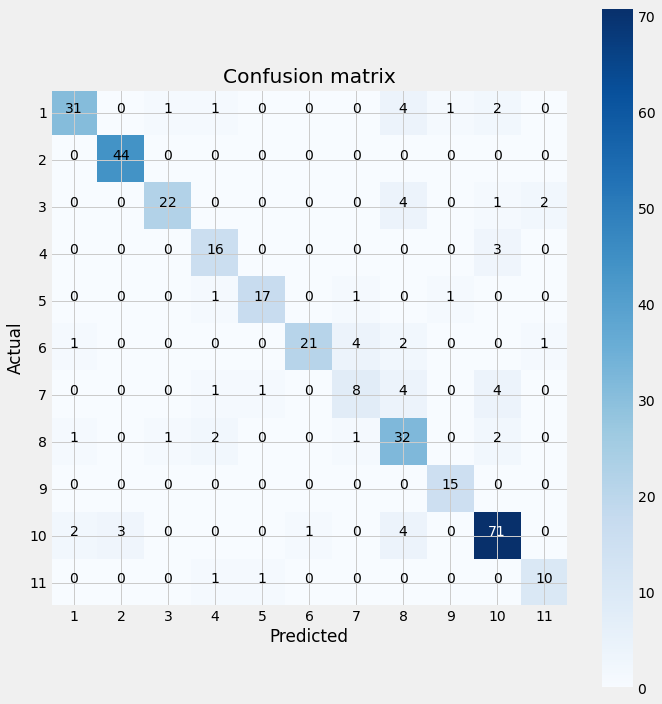

In [64]:
print_model_metrics(gb2_y_preds, gb2_y_score, y2_test)

In [69]:
print(f'Training Accuracy: {xgb2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {xgb2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.8236994219653179


### XGBoost

In [29]:
xgb2, xgb2_y_preds, xgb2_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X2_train, X2_test, y2_train, y2_test, decision_function=False)

Total Runtime: 0.4422461986541748 seconds


Accuracy: 0.8237

Micro Precision: 0.8237
Micro Recall: 0.8237
Micro F1: 0.8237

Macro Precision: 0.8161
Macro Recall: 0.8193
Macro F1-score: 0.8105

Weighted Precision: 0.8351
Weighted Recall: 0.8237
Weighted F1-score: 0.8243


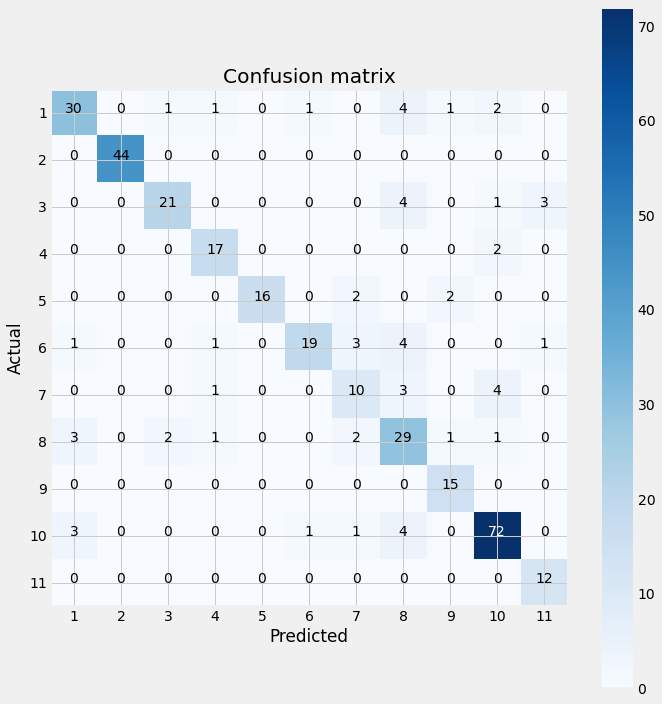

In [30]:
print_model_metrics(xgb2_y_preds, xgb2_y_score, y2_test)

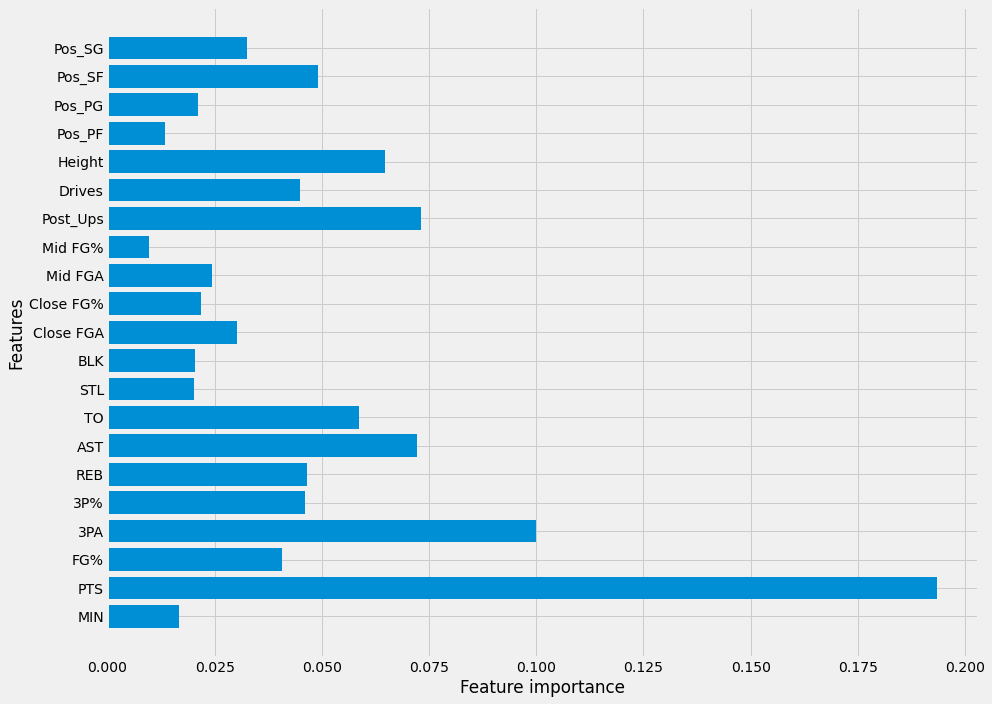

In [31]:
plot_feature_importances(xgb2)

In [34]:
print(f'Training Accuracy: {xgb2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {xgb2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.8236994219653179


**Gridsearch**

In [32]:
xgb2_param_grid = {"min_child_weight": [3, 4],
                  "max_depth": [9],
                  "eta": [.001, .01],
                   "gamma": [0, 1, 5]
                }

xgb2_gs, xgb2_gs_y_preds, xgb2_gs_y_score = build_model(GridSearchCV(xgb2, param_grid=xgb2_param_grid),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 24.74636697769165 seconds


Accuracy: 0.8439

Micro Precision: 0.8439
Micro Recall: 0.8439
Micro F1: 0.8439

Macro Precision: 0.8425
Macro Recall: 0.8380
Macro F1-score: 0.8339

Weighted Precision: 0.8547
Weighted Recall: 0.8439
Weighted F1-score: 0.8440


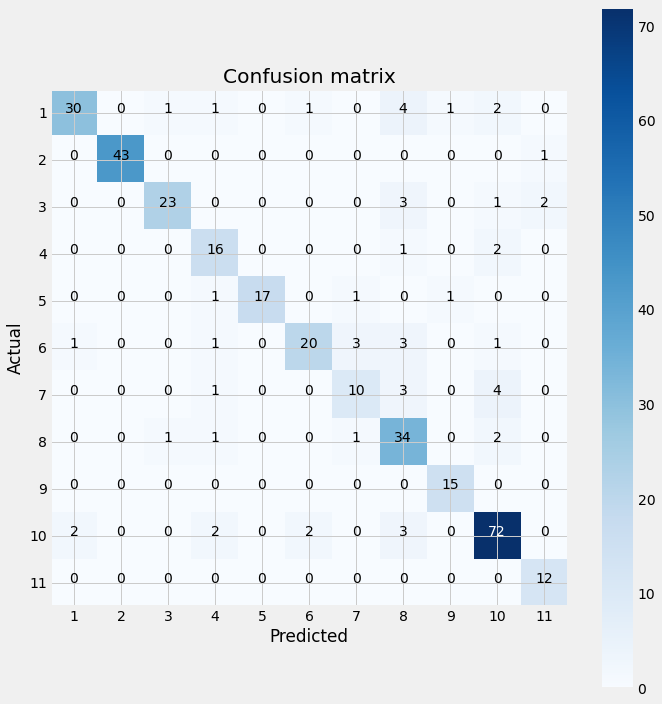

In [33]:
print_model_metrics(xgb2_gs_y_preds, xgb2_gs_y_score, y2_test)

In [34]:
xgb2_gs.best_params_

{'eta': 0.001, 'gamma': 0, 'max_depth': 9, 'min_child_weight': 4}

In [83]:
%reset_selective -f xgb2_man

In [84]:
xgb2_man, xgb2_man_y_preds, xgb2_man_y_score = build_model(XGBClassifier(objective='multi:softmax',
                                                                        eta=0.25, gamma=1,
                                                                        max_depth=7, min_child_weight=5), 
                                            X2_train, X2_test, y2_train, y2_test, decision_function=False)

Total Runtime: 0.554448127746582 seconds


Accuracy: 0.8439

Micro Precision: 0.8439
Micro Recall: 0.8439
Micro F1: 0.8439

Macro Precision: 0.8384
Macro Recall: 0.8341
Macro F1-score: 0.8315

Weighted Precision: 0.8511
Weighted Recall: 0.8439
Weighted F1-score: 0.8434


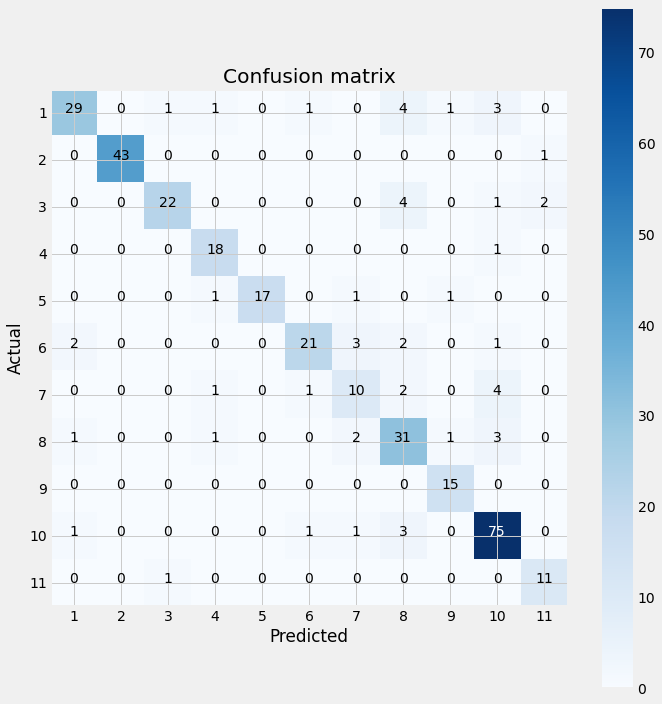

In [85]:
print_model_metrics(xgb2_man_y_preds, xgb2_man_y_score, y2_test)

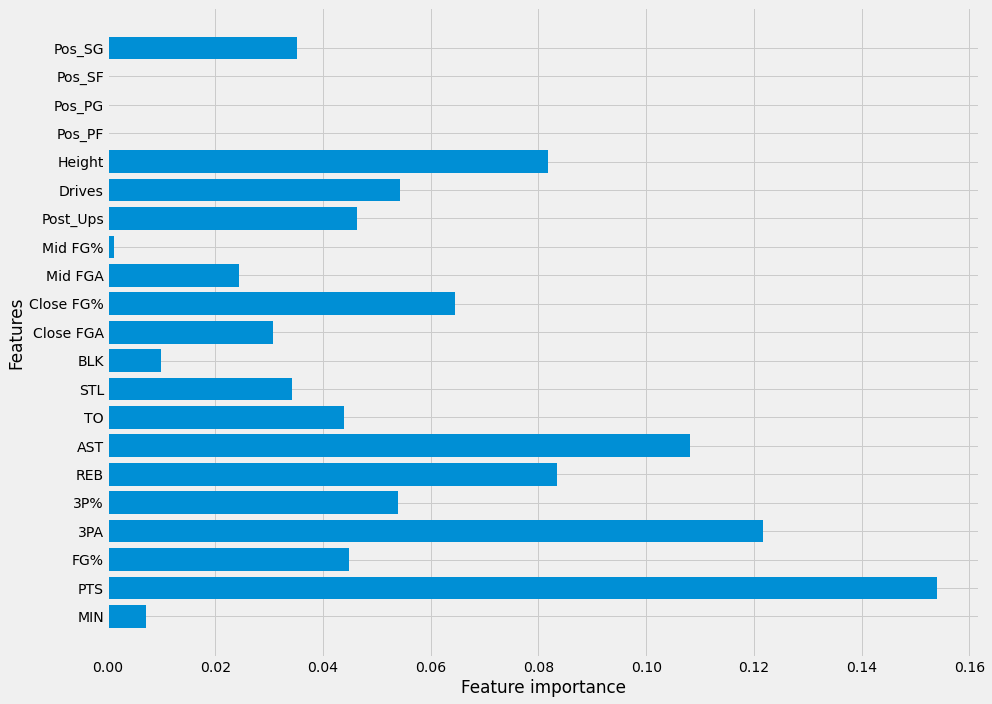

In [28]:
plot_feature_importances(xgb2_man)

In [86]:
xgb2_man.save_model('final_model2.model')

### Neural Network

In [28]:
# binarize target column

binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y2_train)

In [43]:
labels.shape

(1037, 11)

In [114]:
%reset_selective -f model_1

In [44]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(21,)))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dense(11, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [45]:
model_1_results = model_1.fit(X2_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 0s 6ms/step - loss: 2.2990 - acc: 0.2063 - val_loss: 2.1275 - val_acc: 0.3269
Epoch 2/150
26/26 [==============================] - 0s 1ms/step - loss: 2.1017 - acc: 0.2859 - val_loss: 1.9402 - val_acc: 0.4038
Epoch 3/150
26/26 [==============================] - 0s 2ms/step - loss: 1.9275 - acc: 0.3800 - val_loss: 1.7480 - val_acc: 0.4663
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 1.7582 - acc: 0.4331 - val_loss: 1.5704 - val_acc: 0.4760
Epoch 5/150
26/26 [==============================] - 0s 2ms/step - loss: 1.6051 - acc: 0.4536 - val_loss: 1.4471 - val_acc: 0.5385
Epoch 6/150
26/26 [==============================] - 0s 2ms/step - loss: 1.4795 - acc: 0.5030 - val_loss: 1.3363 - val_acc: 0.5481
Epoch 7/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3824 - acc: 0.5211 - val_loss: 1.2591 - val_acc: 0.5625
Epoch 8/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3100 - a

Epoch 125/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4842 - acc: 0.8203 - val_loss: 0.4982 - val_acc: 0.7740
Epoch 126/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4807 - acc: 0.8239 - val_loss: 0.5062 - val_acc: 0.7788
Epoch 127/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4769 - acc: 0.8239 - val_loss: 0.5176 - val_acc: 0.7548
Epoch 128/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4784 - acc: 0.8179 - val_loss: 0.4884 - val_acc: 0.7981
Epoch 129/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4744 - acc: 0.8203 - val_loss: 0.4957 - val_acc: 0.7837
Epoch 130/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4710 - acc: 0.8215 - val_loss: 0.5027 - val_acc: 0.7788
Epoch 131/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4723 - acc: 0.8239 - val_loss: 0.4863 - val_acc: 0.7885
Epoch 132/150
26/26 [==============================] - 0s 1ms/step - 

Model looks a little overfit. The goal further is to address the overfit model and to minimize loss.

In [60]:
%reset_selective -f model_2

In [46]:
model_2 = Sequential()
#model_2.add(Dense(128, activation='tanh', input_shape=(1037,29)))
model_2.add(Dense(128, activation='tanh', input_shape=(21,)))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dropout(.2))
model_2.add(Dense(11, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [47]:
model_2_results = model_2.fit(X2_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 0s 7ms/step - loss: 2.2140 - acc: 0.2473 - val_loss: 1.9643 - val_acc: 0.4038
Epoch 2/150
26/26 [==============================] - 0s 1ms/step - loss: 1.9426 - acc: 0.3945 - val_loss: 1.7100 - val_acc: 0.5048
Epoch 3/150
26/26 [==============================] - 0s 2ms/step - loss: 1.7487 - acc: 0.4343 - val_loss: 1.5385 - val_acc: 0.5288
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 1.5661 - acc: 0.4656 - val_loss: 1.3911 - val_acc: 0.5673
Epoch 5/150
26/26 [==============================] - 0s 2ms/step - loss: 1.4478 - acc: 0.5247 - val_loss: 1.2845 - val_acc: 0.5721
Epoch 6/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3567 - acc: 0.5283 - val_loss: 1.2047 - val_acc: 0.6058
Epoch 7/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2923 - acc: 0.5537 - val_loss: 1.1419 - val_acc: 0.6010
Epoch 8/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2405 - a

Epoch 125/150
26/26 [==============================] - 0s 2ms/step - loss: 0.5870 - acc: 0.7925 - val_loss: 0.4945 - val_acc: 0.7885
Epoch 126/150
26/26 [==============================] - 0s 2ms/step - loss: 0.6104 - acc: 0.7793 - val_loss: 0.5167 - val_acc: 0.8173
Epoch 127/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5944 - acc: 0.7720 - val_loss: 0.5057 - val_acc: 0.7788
Epoch 128/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6288 - acc: 0.7587 - val_loss: 0.4870 - val_acc: 0.7885
Epoch 129/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6017 - acc: 0.7744 - val_loss: 0.5199 - val_acc: 0.8077
Epoch 130/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5812 - acc: 0.7805 - val_loss: 0.4821 - val_acc: 0.8029
Epoch 131/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5999 - acc: 0.7744 - val_loss: 0.5003 - val_acc: 0.7885
Epoch 132/150
26/26 [==============================] - 0s 1ms/step - 

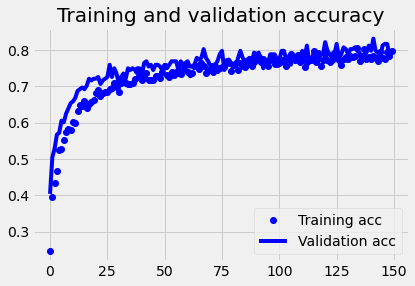

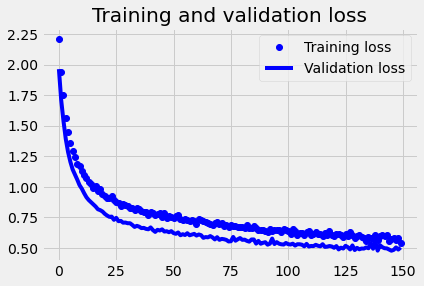

In [48]:
acc = model_2_results.history['acc']
val_acc = model_2_results.history['val_acc']
loss = model_2_results.history['loss']
val_loss = model_2_results.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [66]:
%reset_selective -f model_3

In [49]:
model_3 = Sequential()
#model_3.add(Dense(128, activation='tanh', input_shape=(1037,29)))
model_3.add(Dense(64, activation='tanh', input_shape=(21,)))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dropout(.2))
model_3.add(Dense(11, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [50]:
model_3_results = model_3.fit(X2_train_scaled, labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 2.3306 - acc: 0.1713 - val_loss: 2.1220 - val_acc: 0.3462
Epoch 2/100
26/26 [==============================] - 0s 1ms/step - loss: 2.1065 - acc: 0.3100 - val_loss: 1.9167 - val_acc: 0.4231
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 1.9381 - acc: 0.3752 - val_loss: 1.7468 - val_acc: 0.4952
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 1.7773 - acc: 0.4077 - val_loss: 1.5796 - val_acc: 0.5000
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 1.6445 - acc: 0.4596 - val_loss: 1.4522 - val_acc: 0.5192
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 1.5319 - acc: 0.4753 - val_loss: 1.3513 - val_acc: 0.5577
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 1.4314 - acc: 0.5163 - val_loss: 1.2756 - val_acc: 0.5577
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 1.3709 - a

## Multi-Class Neural Network with Cross Validation

In [30]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, activation='tanh', input_shape=(21,)))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(.2))
    model.add(Dense(11, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=32, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X2_train, labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/150
26/26 [==============================] - 0s 1ms/step - loss: 2.4365 - acc: 0.1942
Epoch 2/150
26/26 [==============================] - 0s 921us/step - loss: 2.1747 - acc: 0.2811
Epoch 3/150
26/26 [==============================] - 0s 1ms/step - loss: 2.0096 - acc: 0.3305
Epoch 4/150
26/26 [==============================] - 0s 1ms/step - loss: 1.8493 - acc: 0.3860
Epoch 5/150
26/26 [==============================] - 0s 934us/step - loss: 1.7320 - acc: 0.4367
Epoch 6/150
26/26 [==============================] - 0s 1ms/step - loss: 1.6451 - acc: 0.4210
Epoch 7/150
26/26 [==============================] - 0s 1ms/step - loss: 1.5318 - acc: 0.4885
Epoch 8/150
26/26 [==============================] - 0s 1ms/step - loss: 1.4677 - acc: 0.4922
Epoch 9/150
26/26 [==============================] - 0s 904us/step - loss: 1.4023 - acc: 0.5199
Epoch 10/150
26/26 [==============================] - 0s 1ms/step - loss: 1.3770 - acc: 0.5464
Epoch 11/150
26/26 [==============================] -

26/26 [==============================] - 0s 688us/step - loss: 1.2148 - acc: 0.5899
Epoch 19/150
26/26 [==============================] - 0s 744us/step - loss: 1.1947 - acc: 0.5838
Epoch 20/150
26/26 [==============================] - 0s 769us/step - loss: 1.1934 - acc: 0.5862
Epoch 21/150
26/26 [==============================] - 0s 738us/step - loss: 1.1610 - acc: 0.5911
Epoch 22/150
26/26 [==============================] - 0s 777us/step - loss: 1.1667 - acc: 0.5995
Epoch 23/150
26/26 [==============================] - 0s 773us/step - loss: 1.1180 - acc: 0.5983
Epoch 24/150
26/26 [==============================] - 0s 898us/step - loss: 1.1263 - acc: 0.5911
Epoch 25/150
26/26 [==============================] - 0s 727us/step - loss: 1.0640 - acc: 0.6405
Epoch 26/150
26/26 [==============================] - 0s 697us/step - loss: 1.0819 - acc: 0.6357
Epoch 27/150
26/26 [==============================] - 0s 733us/step - loss: 1.0659 - acc: 0.6466
Epoch 28/150
26/26 [=======================

26/26 [==============================] - 0s 1ms/step - loss: 0.8388 - acc: 0.6952
Epoch 36/150
26/26 [==============================] - 0s 808us/step - loss: 0.7955 - acc: 0.7229
Epoch 37/150
26/26 [==============================] - 0s 792us/step - loss: 0.7982 - acc: 0.7072
Epoch 38/150
26/26 [==============================] - 0s 770us/step - loss: 0.7872 - acc: 0.7024
Epoch 39/150
26/26 [==============================] - 0s 775us/step - loss: 0.7981 - acc: 0.7108
Epoch 40/150
26/26 [==============================] - 0s 668us/step - loss: 0.7793 - acc: 0.7108
Epoch 41/150
26/26 [==============================] - 0s 678us/step - loss: 0.7453 - acc: 0.7386
Epoch 42/150
26/26 [==============================] - 0s 669us/step - loss: 0.7559 - acc: 0.7193
Epoch 43/150
26/26 [==============================] - 0s 719us/step - loss: 0.7672 - acc: 0.7193
Epoch 44/150
26/26 [==============================] - 0s 763us/step - loss: 0.7228 - acc: 0.7373
Epoch 45/150
26/26 [=========================

26/26 [==============================] - 0s 775us/step - loss: 0.7956 - acc: 0.7217
Epoch 53/150
26/26 [==============================] - 0s 662us/step - loss: 0.7892 - acc: 0.7337
Epoch 54/150
26/26 [==============================] - 0s 717us/step - loss: 0.7812 - acc: 0.7229
Epoch 55/150
26/26 [==============================] - 0s 718us/step - loss: 0.7847 - acc: 0.7205
Epoch 56/150
26/26 [==============================] - 0s 745us/step - loss: 0.7744 - acc: 0.7325
Epoch 57/150
26/26 [==============================] - 0s 817us/step - loss: 0.7612 - acc: 0.7398
Epoch 58/150
26/26 [==============================] - 0s 913us/step - loss: 0.7448 - acc: 0.7410
Epoch 59/150
26/26 [==============================] - 0s 926us/step - loss: 0.7706 - acc: 0.7205
Epoch 60/150
26/26 [==============================] - 0s 837us/step - loss: 0.7524 - acc: 0.7398
Epoch 61/150
26/26 [==============================] - 0s 721us/step - loss: 0.7526 - acc: 0.7253
Epoch 62/150
26/26 [=======================

26/26 [==============================] - 0s 760us/step - loss: 0.7239 - acc: 0.7265
Epoch 70/150
26/26 [==============================] - 0s 648us/step - loss: 0.7086 - acc: 0.7446
Epoch 71/150
26/26 [==============================] - 0s 726us/step - loss: 0.7204 - acc: 0.7325
Epoch 72/150
26/26 [==============================] - 0s 813us/step - loss: 0.7405 - acc: 0.7265
Epoch 73/150
26/26 [==============================] - 0s 815us/step - loss: 0.7037 - acc: 0.7458
Epoch 74/150
26/26 [==============================] - 0s 698us/step - loss: 0.7130 - acc: 0.7410
Epoch 75/150
26/26 [==============================] - 0s 727us/step - loss: 0.7058 - acc: 0.7470
Epoch 76/150
26/26 [==============================] - 0s 753us/step - loss: 0.6864 - acc: 0.7590
Epoch 77/150
26/26 [==============================] - 0s 717us/step - loss: 0.6670 - acc: 0.7578
Epoch 78/150
26/26 [==============================] - 0s 761us/step - loss: 0.6743 - acc: 0.7494
Epoch 79/150
26/26 [=======================

Final Model will be the XGBoost model with 84.39% test accuracy

# Plotting

In [88]:
xgboost = XGBClassifier()
xgboost.load_model('final_model2.model')

In [92]:
#unlabeled_df['Class'] = xgboost.predict(pred_set)
#new_labeled_df = pd.concat([prelabeled_df, unlabeled_df])
#new_labeled_df.to_csv('results2/ss_results2.csv', index=False)

In [93]:
# RUN THIS TO USE PLOTTING FUNCTION

df = pd.read_csv('results2/ss_results2.csv')
df.Class.replace([10], [0], inplace=True)
classes = ['Role Player', 'Perimeter Scorer', 'Traditional Big', 'Stretch Big', 'Pass-First Guard', 
           'Ball-Dominant Scorer', 'Volume Scorer', 'Athletic Slasher', 'Versatile Role Player',
           'High Usage Big']

df_2015 = df[df['Player'].str.contains('2015')]
df_2016 = df[df['Player'].str.contains('2016')]
df_2017 = df[df['Player'].str.contains('2017')]
df_2018 = df[df['Player'].str.contains('2018')]
df_2019 = df[df['Player'].str.contains('2019')]
df_2020 = df[df['Player'].str.contains('2020')]

df_2015.reset_index(drop=True, inplace=True)
df_2016.reset_index(drop=True, inplace=True)
df_2017.reset_index(drop=True, inplace=True)
df_2018.reset_index(drop=True, inplace=True)
df_2019.reset_index(drop=True, inplace=True)
df_2020.reset_index(drop=True, inplace=True)

In [94]:
plot_radar(df_2015, classes, 2015, average=True)

FileNotFoundError: [Errno 2] No such file or directory: 'results/radar_data/Semi-Supervised/Role Player/good'

In [55]:
plot_radar(df_2015, classes, 2015)

In [56]:
plot_radar(df_2016, classes, 2016)

In [57]:
plot_radar(df_2017, classes, 2017)

In [58]:
plot_radar(df_2018, classes, 2018)

In [59]:
plot_radar(df_2019, classes, 2019)

In [60]:
plot_radar(df_2020, classes, 2020)

In [8]:
plot_radar(df, classes, average=True)